# Group 14 - Project FP01
## Time series anomaly detection - LSTM-ED

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data, predict_anomaly_score
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve, plot_all_anomalies_over_time
from metrics import Confidence, anomaly_detection_metric, compute_metrics, compute_various_thresholds

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')

# transform in like collision
collisions['Timestamp'] = collisions_adjusted
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collision_rec5['Timestamp'] = collisions_adjusted_rec_5

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



In [5]:
# plot_signals(df, df_action, "Normal signals", saveplot=False)
# plot_signals(df_collision, df_action_collision, "Collision signals", saveplot=False)
# plot_signals(df_collision_1, df_action_collision_1, "Collision signals 1", saveplot=False)
# plot_signals(df_collision_5, df_action_collision_5, "Collision signals 5", saveplot=False)

### Features Exctraction

In [6]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 156.0309295654297 seconds ---


In [7]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

In [8]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_adjusted_rec_1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_adjusted_rec_5)

In [9]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']


## LSTM-ED

### test batch size 1

In [10]:
from algorithms.lstm_enc_dec_axl import LSTMED

classifier = LSTMED(
    name='LSTM-ED',
    num_epochs=100,
    batch_size=64,
    lr=1e-4,
    hidden_size=64,
    sequence_length=100,
    train_gaussian_percentage=0.25,
    n_layers=(2, 2),
    use_bias=(True, True),
    dropout=(0.1, 0.1),
    seed=42,
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True
)
# Train the LSTM on normal data
classifier.fit(X_train)
print("LSTM-ED training completed.")


100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


LSTM-ED training completed.


In [11]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [12]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 10 with threshold 1097.621823775651, std
Number of anomalies detected: 126 with threshold 127.36803176551962, mad
Number of anomalies detected: 16 with threshold 1044.016528538937, percentile
Number of anomalies detected: 4 with threshold 1549.7001543587571, IQR

Number of anomalies detected: 10 with threshold 803.2307647357245, std
Number of anomalies detected: 51 with threshold 94.27385077020129, mad
Number of anomalies detected: 9 with threshold 980.4431724000284, percentile
Number of anomalies detected: 18 with threshold 314.64287399641546, IQR

Number of anomalies detected: 2 with threshold 1334.3558545671337, std
Number of anomalies detected: 2 with threshold 1499.025429087791, mad
Number of anomalies detected: 8 with threshold 1075.4793559938475, percentile
Number of anomalies detected: 1 with threshold 1900.2704341139006, IQR



### Anomaly Detection

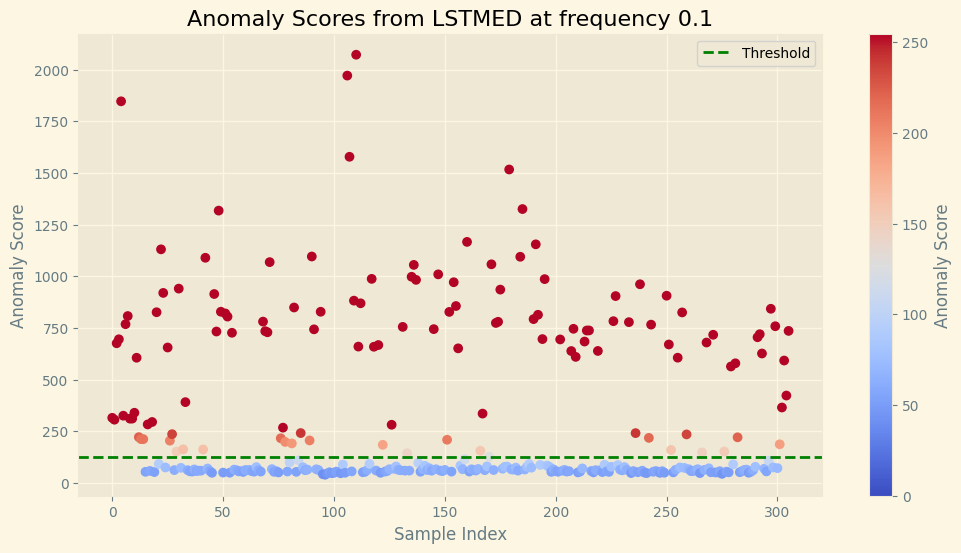

Number of anomalies detected: 126


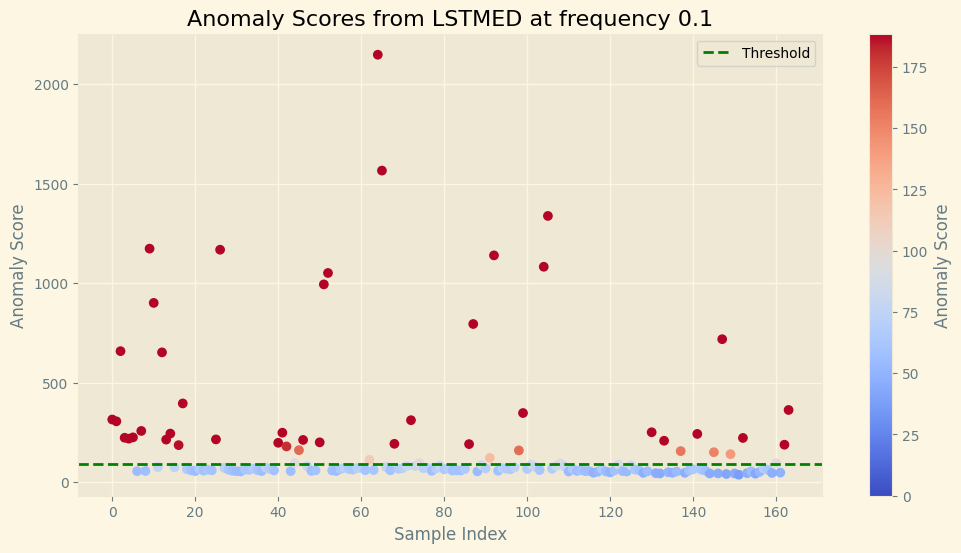

Number of anomalies detected: 51


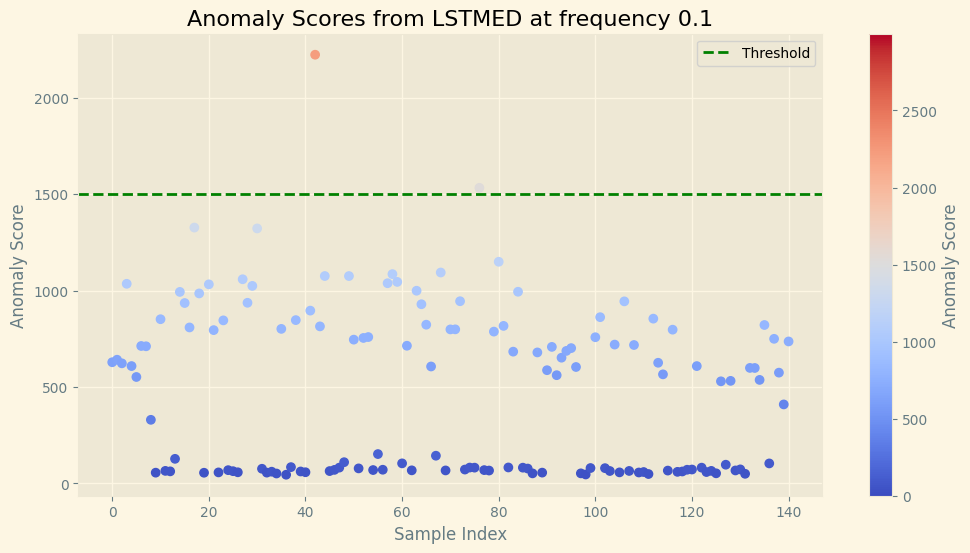

Number of anomalies detected: 2


In [13]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[1])

In [14]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 56)

In [15]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[1])

ROC AUC Score: 0.9747
Detected anomaly class: 1
Threshold: 127.3680
F1 Score: 0.9091
Accuracy: 0.9314
Precision: 0.8333
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.90      0.94       201
           1       0.83      1.00      0.91       105

    accuracy                           0.93       306
   macro avg       0.92      0.95      0.93       306
weighted avg       0.94      0.93      0.93       306

############################################
ROC AUC Score: 0.9743
Detected anomaly class: 1
Threshold: 94.2739
F1 Score: 0.8140
Accuracy: 0.9024
Precision: 0.6863
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       129
           1       0.69      1.00      0.81        35

    accuracy                           0.90       164
   macro avg       0.84      0.94      0.87       164
weighted avg       0.93      0.90      0.91       164

################################

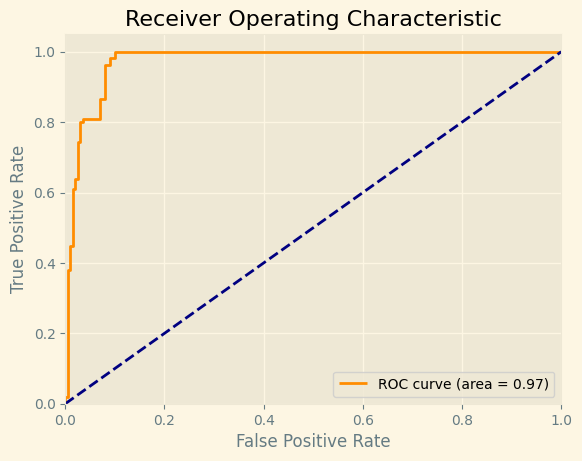

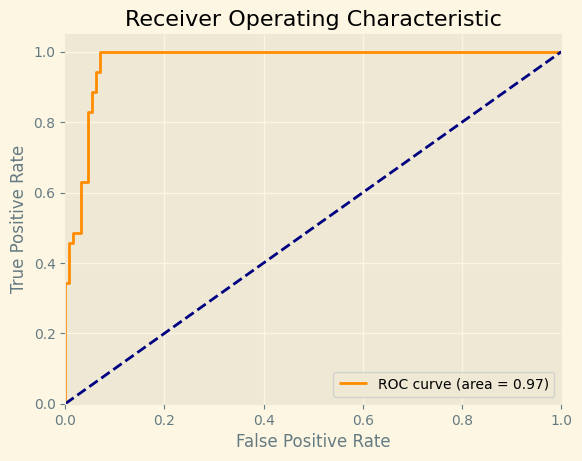

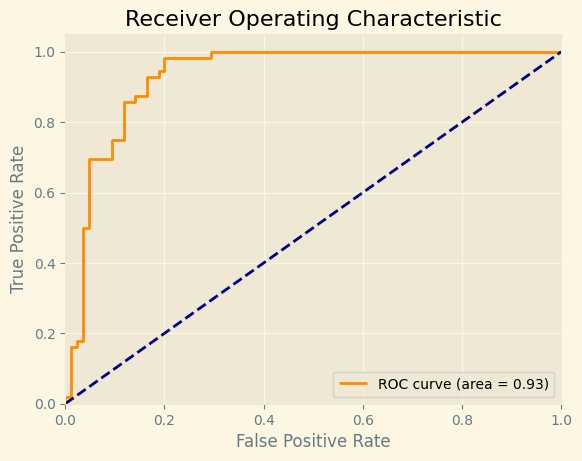

In [16]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

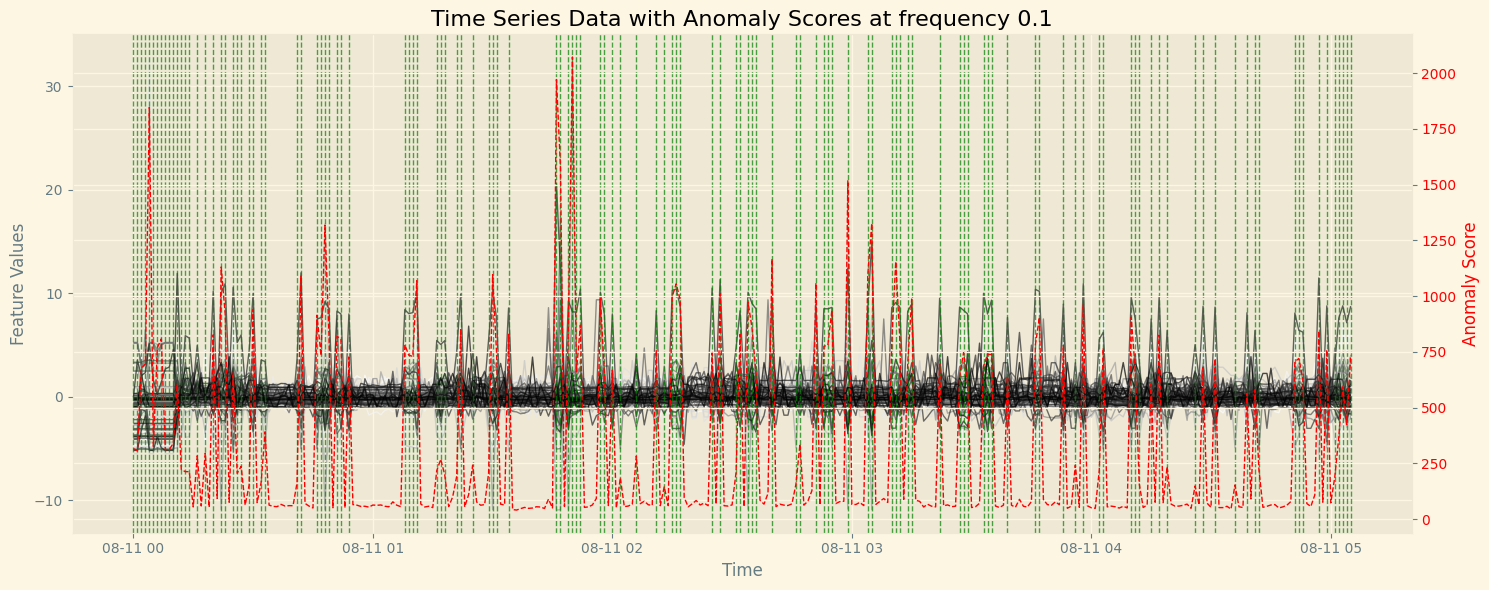

Top 126 Anomalies:
              timestamp  anomaly_score  \
110 2022-08-11 01:50:00    2072.475020   
106 2022-08-11 01:46:00    1971.532959   
4   2022-08-11 00:04:00    1847.051120   
107 2022-08-11 01:47:00    1578.646968   
179 2022-08-11 02:59:00    1517.137259   
..                  ...            ...   
166 2022-08-11 02:46:00     156.219486   
276 2022-08-11 04:36:00     152.533583   
29  2022-08-11 00:29:00     151.772040   
266 2022-08-11 04:26:00     148.091830   
133 2022-08-11 02:13:00     144.165585   

     machine_nameKuka Robot_apparent_power-_Average power  \
110                                          -0.911260      
106                                          -1.885449      
4                                            -5.323114      
107                                          -1.181816      
179                                          -1.338344      
..                                                 ...      
166                                           0.5

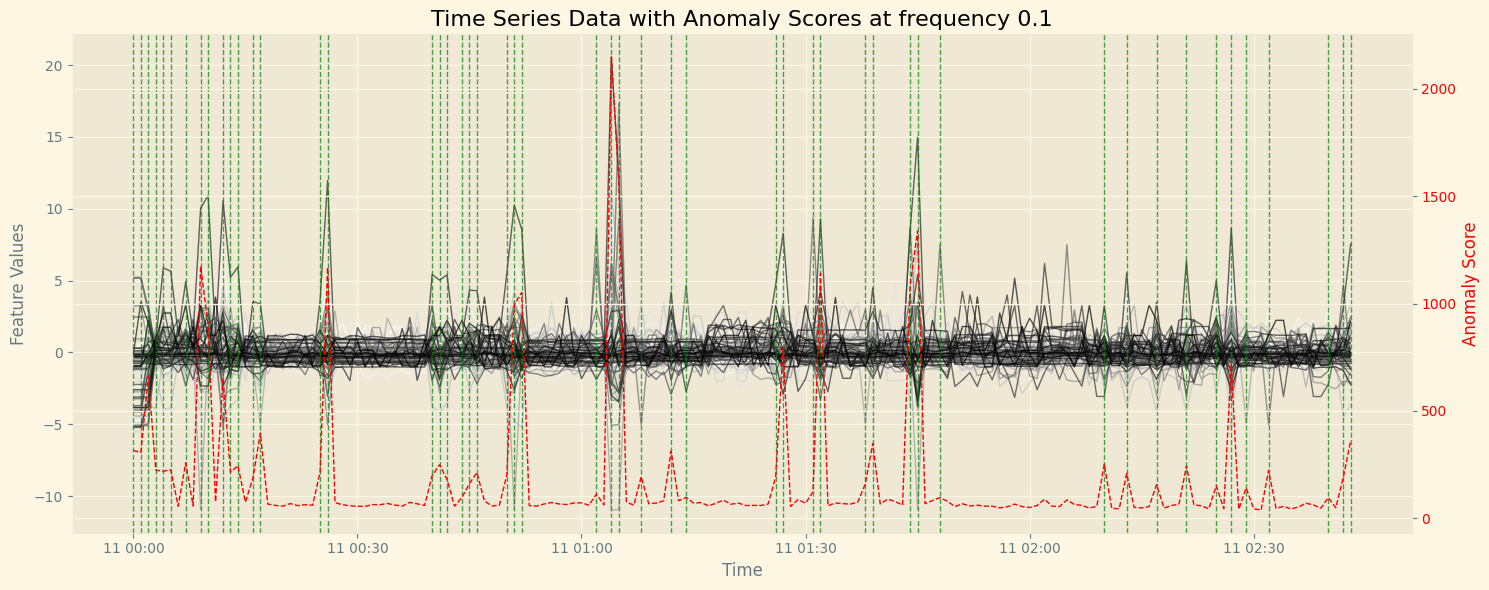

Top 51 Anomalies:
              timestamp  anomaly_score  \
64  2022-08-11 01:04:00    2148.260206   
65  2022-08-11 01:05:00    1566.047746   
105 2022-08-11 01:45:00    1338.315315   
9   2022-08-11 00:09:00    1173.959058   
26  2022-08-11 00:26:00    1168.466081   
92  2022-08-11 01:32:00    1140.129966   
104 2022-08-11 01:44:00    1082.875209   
52  2022-08-11 00:52:00    1051.675407   
51  2022-08-11 00:51:00     994.411178   
10  2022-08-11 00:10:00     901.291138   
87  2022-08-11 01:27:00     795.342151   
147 2022-08-11 02:27:00     718.947058   
2   2022-08-11 00:02:00     658.917288   
12  2022-08-11 00:12:00     652.792419   
17  2022-08-11 00:17:00     396.135002   
163 2022-08-11 02:43:00     363.371576   
99  2022-08-11 01:39:00     347.966631   
0   2022-08-11 00:00:00     315.449863   
72  2022-08-11 01:12:00     311.977276   
1   2022-08-11 00:01:00     306.363488   
7   2022-08-11 00:07:00     257.985348   
130 2022-08-11 02:10:00     251.450163   
41  2022-08-11 0

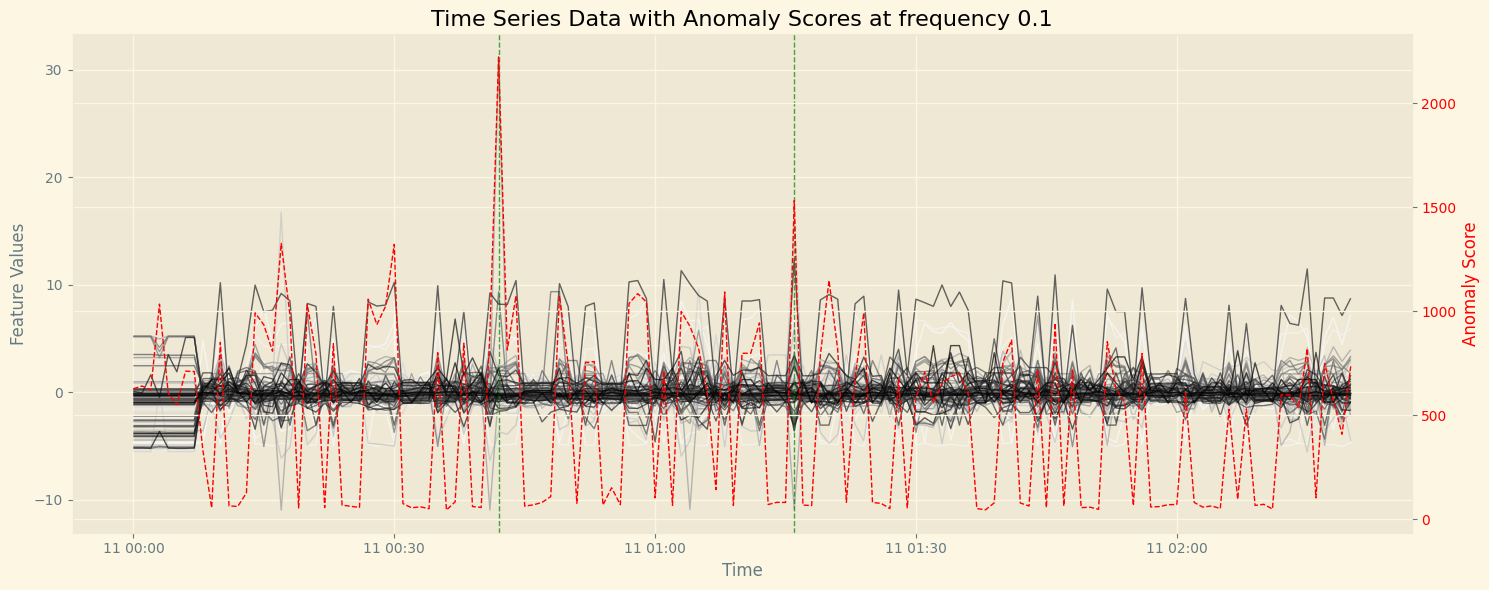

Top 2 Anomalies:
             timestamp  anomaly_score  \
42 2022-08-11 00:42:00    2223.030147   
76 2022-08-11 01:16:00    1532.854901   

    machine_nameKuka Robot_apparent_power-_Average power  \
42                                          -0.911260      
76                                          -1.338344      

    machine_nameKuka Robot_apparent_power-_Variance  \
42                                         0.246879   
76                                         0.201584   

    machine_nameKuka Robot_current-_Min  \
42                             0.235311   
76                            -0.957586   

    machine_nameKuka Robot_phase_angle-_Average power  \
42                                          -1.270309   
76                                          -1.021451   

    machine_nameKuka Robot_phase_angle-_Variance  \
42                                      4.879634   
76                                      7.266342   

    machine_nameKuka Robot_power-_ECDF Percentile_0  

In [17]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)